In [385]:
import pandas as pd
import numpy as np
import time

import urllib
from urllib.parse import urlparse
import httplib2 as http
import json
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
sns.set_style('darkgrid')
%matplotlib inline

%load_ext autoreload
%autoreload 2

from my_functions import Distance_Data

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Getting Data

## LTA API
You can read more about LTA's Datamall API here:
https://datamall.lta.gov.sg/content/dam/datamall/datasets/LTA_DataMall_API_User_Guide.pdf

### Bus Stop Data

In [386]:
# Create an empty dataframe to store the data
stop_df = pd.DataFrame(columns = ['BusStopCode', 'RoadName', \
                                    'Description', 'Latitude', \
                                    'Longitude'])

In [387]:
# Extracting bus stop data
api_file_path = 'data/api_key.txt'
with open(api_file_path, 'r') as f:
            api_key = f.read().strip()
uri =  'http://datamall2.mytransport.sg/ltaodataservice/'
path = 'BusStops'
headers = { 'AccountKey' : api_key, 'accept' : 'application/json'}
method = 'GET'
h = http.Http()

for i in range(0,5500,500): # There are about 5000+ bus stops currently and they return a limit of 500 at a go
    skip = '?$skip=' + str(i)
    target = urlparse(uri + path + skip)
    print(f'The target url is {target.geturl()}')
    response, content = h.request(target.geturl(),method,'',headers)
    print(response)
    data = json.loads(content)
    df = pd.DataFrame(data['value'])
    stop_df =  pd.concat([stop_df, df], ignore_index=True)

The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=0
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-SG', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=0'}
The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=500
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-SG', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=500'}
The target url is http://datamall2.mytransport.sg/ltaodataservice/BusStops?$skip=1000
{'date': 'Mon, 27 Mar 2023 06:45:55 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': '

In [388]:
print(f'The dataframe has a shape of {stop_df.shape}')

The dataframe has a shape of (5083, 5)


In [389]:
# explore the data gotten from the API
stop_df.head()

,BusStopCode,RoadName,Description,Latitude,Longitude
0,01012,Victoria St,Hotel Grand Pacific,1.30,103.85
1,01013,Victoria St,St. Joseph's Ch,1.30,103.85
2,01019,Victoria St,Bras Basah Cplx,1.30,103.85
3,01029,Nth Bridge Rd,Opp Natl Lib,1.30,103.85
4,01039,Nth Bridge Rd,Bugis Cube,1.30,103.86


In [390]:
stop_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5083 entries, 0 to 5082
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   BusStopCode  5083 non-null   object 
 1   RoadName     5083 non-null   object 
 2   Description  5083 non-null   object 
 3   Latitude     5083 non-null   float64
 4   Longitude    5083 non-null   float64
dtypes: float64(2), object(3)
memory usage: 198.7+ KB


In [391]:
# check for duplicates
stop_df.duplicated().sum()

0

In [392]:
# check for null values
stop_df.isnull().sum()

BusStopCode    0
RoadName       0
Description    0
Latitude       0
Longitude      0
dtype: int64

In [393]:
# check for unique values
stop_df.nunique()

BusStopCode    5083
RoadName        838
Description    4542
Latitude       5083
Longitude      5082
dtype: int64

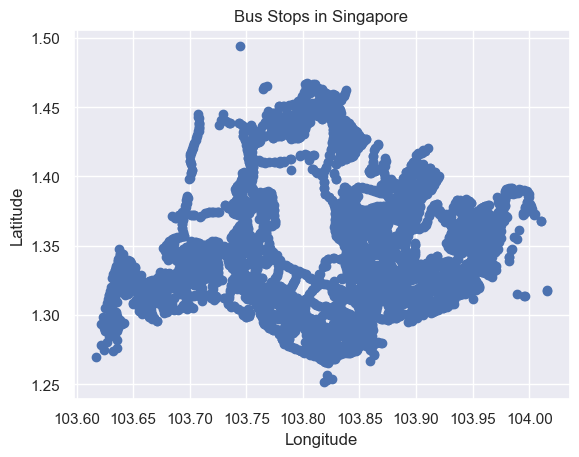

In [394]:
# plot latitude and longitude on a scatter plot to visualize
plt.scatter(stop_df['Longitude'],stop_df['Latitude'])
plt.title('Bus Stops in Singapore')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [395]:
# always export the data to a file locally if possible in case the kernel crashes

# file name
csv_file_name = 'data/bus_stops.csv'

# export data to csv
stop_df.to_csv(csv_file_name)

### Bus Traffic Data

In [396]:
# Extracting bus stop data
api_file_path = 'data/api_key.txt'
with open(api_file_path, 'r') as f:
            api_key = f.read().strip()
uri =  'http://datamall2.mytransport.sg/ltaodataservice/'
path = 'PV/Bus'
headers = { 'AccountKey' : api_key, 'accept' : 'application/json'}
method = 'GET'
h = http.Http()

for i in ['202302']: # put the month you want in YYYYMM format, you can only get up to the past 3 months
    skip = '?Date=' + i
    target = urlparse(uri + path + skip)
    print(f'The target url is {target.geturl()}')
    response, content = h.request(target.geturl(),method,'',headers)
    print(response)
    data = json.loads(content)
    print(data['value']) # you will get a link to download a csv file

The target url is http://datamall2.mytransport.sg/ltaodataservice/PV/Bus?Date=202302
{'date': 'Mon, 27 Mar 2023 06:45:56 GMT', 'content-type': 'application/json;charset=UTF-8', 'transfer-encoding': 'chunked', 'connection': 'keep-alive', 'cache-control': 'no-store', 'content-language': 'en-US', 'status': '200', 'content-location': 'http://datamall2.mytransport.sg/ltaodataservice/PV/Bus?Date=202302'}
[{'Link': 'https://ltafarecard.s3.ap-southeast-1.amazonaws.com/202302/transport_node_bus_202302.zip?X-Amz-Security-Token=IQoJb3JpZ2luX2VjEE8aDmFwLXNvdXRoZWFzdC0xIkcwRQIhALEzNu96Rfe%2BhCHUbY2LkUUjgbTgAi0t1%2FbzytW5qF9YAiBWHfCl6P5lZCj8GVMC9BK2lRcVzAogd9ogMxX9PDScjCrCBQgoEAMaDDM0MDY0NTM4MTMwNCIMIveTI21v9PMVvto1Kp8FZWrfQ%2FxI%2Fcrozoiok%2FHjl99csy6Q7i8p53nGZqKWTBsMLcqL7a2elNfb63wuVlWhEXhU%2BWy2SIGbXcmyMSv8WhFp9a%2FMjGfwDwdUYCWyoMdoKKX3Stcgub0QkP%2Bkwau8RXJJuWueshvGSDobIXjgK5F3cVBEKfE9UXBrDFq6ZB1zkfYQqB08DKtTZqZkNr19aaYG5UfFNq1bKvVbyVY6f3HRPBnXpmMKhtVJL%2ByM4Zkv7AbUuymohKWeHUdsIf%2BFMyIaRUQU%2B3e

In [397]:
# import all the csvs and concat them
df = pd.read_csv('data/transport_node_bus_202211.csv')
df1 = pd.read_csv('data/transport_node_bus_202212.csv')
df2 = pd.read_csv('data/transport_node_bus_202301.csv')
df3 = pd.read_csv('data/transport_node_bus_202302.csv')

traffic_df = pd.concat([df,df1,df2,df3], ignore_index=True)

In [398]:
print(f'The dataframe has a shape of {traffic_df.shape}')

The dataframe has a shape of (785988, 7)


In [399]:
# explore the data gotten from the API
traffic_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_TYPE,PT_CODE,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
0,2022-11,WEEKDAY,17,BUS,45379,375,368
1,2022-11,WEEKENDS/HOLIDAY,17,BUS,45379,142,102
2,2022-11,WEEKENDS/HOLIDAY,13,BUS,80051,965,902
3,2022-11,WEEKDAY,13,BUS,80051,2329,2319
4,2022-11,WEEKENDS/HOLIDAY,8,BUS,3511,50,133


In [400]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785988 entries, 0 to 785987
Data columns (total 7 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   YEAR_MONTH            785988 non-null  object
 1   DAY_TYPE              785988 non-null  object
 2   TIME_PER_HOUR         785988 non-null  int64 
 3   PT_TYPE               785988 non-null  object
 4   PT_CODE               785988 non-null  int64 
 5   TOTAL_TAP_IN_VOLUME   785988 non-null  int64 
 6   TOTAL_TAP_OUT_VOLUME  785988 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 42.0+ MB


In [401]:
# check for duplicates
traffic_df.duplicated().sum()

0

In [402]:
# check for null values
traffic_df.isnull().sum()

YEAR_MONTH              0
DAY_TYPE                0
TIME_PER_HOUR           0
PT_TYPE                 0
PT_CODE                 0
TOTAL_TAP_IN_VOLUME     0
TOTAL_TAP_OUT_VOLUME    0
dtype: int64

In [403]:
# check for unique values
traffic_df.nunique()

YEAR_MONTH                 4
DAY_TYPE                   2
TIME_PER_HOUR             24
PT_TYPE                    1
PT_CODE                 5082
TOTAL_TAP_IN_VOLUME     9042
TOTAL_TAP_OUT_VOLUME    9171
dtype: int64

In [404]:
# drop useless columns
traffic_df.drop(columns = ['PT_TYPE'], inplace = True)

In [405]:
# convert column to correct data type
traffic_df['PT_CODE']=traffic_df['PT_CODE'].astype('str')

# for each value in PT_code find out the length
traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# if length of PT_CODE is 4, add a 0 in front
traffic_df['PT_CODE'] = traffic_df['PT_CODE'].apply(lambda x: '0' + x if len(x) == 4 else x)

traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# drop the PT_CODE_LEN column
traffic_df.drop('PT_CODE_LEN', axis=1, inplace=True)

print('converted all PT_CODE to 5 digits')

5    750212
4     35776
Name: PT_CODE_LEN, dtype: int64
5    785988
Name: PT_CODE_LEN, dtype: int64
converted all PT_CODE to 5 digits


In [406]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 785988 entries, 0 to 785987
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   YEAR_MONTH            785988 non-null  object
 1   DAY_TYPE              785988 non-null  object
 2   TIME_PER_HOUR         785988 non-null  int64 
 3   PT_CODE               785988 non-null  object
 4   TOTAL_TAP_IN_VOLUME   785988 non-null  int64 
 5   TOTAL_TAP_OUT_VOLUME  785988 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 36.0+ MB


In [407]:
traffic_df.describe()

,TIME_PER_HOUR,TOTAL_TAP_IN_VOLUME,TOTAL_TAP_OUT_VOLUME
count,785988.00,785988.00,785988.00
mean,13.29,387.32,387.31
std,6.12,1350.92,1295.69
min,0.00,0.00,0.00
25%,9.00,20.00,22.00
50%,14.00,101.00,108.00
75%,18.00,346.00,349.00
max,23.00,113537.00,92366.00


In [408]:
# always export the data to a file locally if possible in case the kernel crashes

# file name
csv_file_name = 'data/traffic_data.csv'

# export data to csv
traffic_df.to_csv(csv_file_name)

# Importing Data

## CSV Files

In [422]:
# file path
csv = 'data/mcdonalds_data.csv'

# import data to csv
mcd_df = pd.read_csv(csv)

print(mcd_df.head())

                                 title  \
0          McDonald's Tampines East CC   
1             McDonald's Tampines Mall   
2          McDonald's Tampines West CC   
3           McDonald's Bedok Reservoir   
4  McDonald's Pasir Ris Sports Complex   

                                             address  latitude  longitude  \
0  10 Tampines St 23, #01-01 Tampines East Commun...      1.35     103.95   
1  4 Tampines Central 5, #01 - 33 Tampines Mall, ...      1.35     103.94   
2  5 Tampines Ave 3, #01-01 Tampines West Communi...      1.35     103.94   
3  632 Bedok Reservoir Rd, #01-850, Singapore 470632      1.33     103.91   
4  120 Pasir Ris Central, #01-12 Sports Centre, S...      1.37     103.95   

  classification planning_area  pa_population  pa_income            subzone  \
0         Medium      Tampines         265690       0.00      Tampines East   
1         Medium      Tampines         265690       0.00      Tampines East   
2         Medium      Tampines         265690  

In [410]:
# file path
csv = 'data/traffic_data.csv'

# import data to csv
traffic_df = pd.read_csv(csv,index_col=0)

# convert column to correct data type
traffic_df['PT_CODE']=traffic_df['PT_CODE'].astype('str')

# for each value in PT_code find out the length
traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print(traffic_df['PT_CODE_LEN'].value_counts())

# if length of PT_CODE is 4, add a 0 in front
traffic_df['PT_CODE'] = traffic_df['PT_CODE'].apply(lambda x: '0' + x if len(x) == 4 else x)

traffic_df['PT_CODE_LEN'] = traffic_df['PT_CODE'].apply(lambda x: len(x))
print()
print(traffic_df['PT_CODE_LEN'].value_counts())
print('converted all PT_CODE to 5 digits')

# drop the PT_CODE_LEN column
traffic_df.drop('PT_CODE_LEN', axis=1, inplace=True)

print()
print(traffic_df.head())

5    750212
4     35776
Name: PT_CODE_LEN, dtype: int64

5    785988
Name: PT_CODE_LEN, dtype: int64
converted all PT_CODE to 5 digits

  YEAR_MONTH          DAY_TYPE  TIME_PER_HOUR PT_CODE  TOTAL_TAP_IN_VOLUME  \
0    2022-11           WEEKDAY             17   45379                  375   
1    2022-11  WEEKENDS/HOLIDAY             17   45379                  142   
2    2022-11  WEEKENDS/HOLIDAY             13   80051                  965   
3    2022-11           WEEKDAY             13   80051                 2329   
4    2022-11  WEEKENDS/HOLIDAY              8   03511                   50   

   TOTAL_TAP_OUT_VOLUME  
0                   368  
1                   102  
2                   902  
3                  2319  
4                   133  


In [411]:
# file path
csv = 'data/bus_stops.csv'

# import data to csv
stops_df = pd.read_csv(csv, index_col=0)

# convert column to correct data type
stops_df['BusStopCode']=stops_df['BusStopCode'].astype('str')

# for each value in BusStopCode find out the length
stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print(stops_df['BusStopCode_LEN'].value_counts())

# if length of BusStopCode is 4, add a 0 in front
stops_df['BusStopCode'] = stops_df['BusStopCode'].apply(lambda x: '0' + x if len(x) == 4 else x)

stops_df['BusStopCode_LEN'] = stops_df['BusStopCode'].apply(lambda x: len(x))
print()
print(stops_df['BusStopCode_LEN'].value_counts())
print('converted all BusStopCode to 5 digits')
# drop the BusStopCode_LEN column
stops_df.drop('BusStopCode_LEN', axis=1, inplace=True)

stops_df = stops_df.drop(columns=['RoadName','Description'])
stops_df['BusStopCode']=stops_df['BusStopCode'].astype(str)

pd.set_option('display.float_format', lambda x: '%.5f' % x)
print()
print(stops_df.head())
pd.set_option('display.float_format', lambda x: '%.2f' % x)

5    4851
4     232
Name: BusStopCode_LEN, dtype: int64

5    5083
Name: BusStopCode_LEN, dtype: int64
converted all BusStopCode to 5 digits

  BusStopCode  Latitude  Longitude
0       01012   1.29685  103.85254
1       01013   1.29771  103.85322
2       01019   1.29699  103.85302
3       01029   1.29667  103.85441
4       01039   1.29821  103.85549


In [412]:
# Data obtained from 
# https://data.gov.sg/dataset/hdb-property-information
# Last updated 4 Jan 2023

# file path
csv = 'data/hdb-property-information.csv'

# import data to csv
hdb_info_df = pd.read_csv(csv)

print(hdb_info_df.head())

  blk_no             street  max_floor_lvl  year_completed residential  \
0      1           BEACH RD             16            1970           Y   
1      1    BEDOK STH AVE 1             14            1975           Y   
2      1      CANTONMENT RD              2            2010           N   
3      1       CHAI CHEE RD             15            1982           Y   
4      1  CHANGI VILLAGE RD              4            1975           Y   

  commercial market_hawker miscellaneous multistorey_carpark  \
0          Y             N             N                   N   
1          N             N             Y                   N   
2          Y             N             N                   N   
3          N             N             N                   N   
4          Y             N             N                   N   

  precinct_pavilion bldg_contract_town  total_dwelling_units  1room_sold  \
0                 N                KWN                   142           0   
1                 

In [413]:
# import other data previously feature engineered
hdb_df = pd.read_csv('data/hdb_df.csv')
hawker_df = pd.read_csv('data/hawker_df.csv')

hdb_02 = pd.read_csv('data/hdb_0.2.csv')
hdb_05 = pd.read_csv('data/hdb_0.5.csv')
hdb_1 = pd.read_csv('data/hdb_1.csv')
hdb_2 = pd.read_csv('data/hdb_2.csv')

hawker_02 = pd.read_csv('data/hawker_0.2.csv')
hawker_05 = pd.read_csv('data/hawker_0.5.csv')
hawker_1 = pd.read_csv('data/hawker_1.csv')
hawker_2 = pd.read_csv('data/hawker_2.csv')

# EDA & Feature Engineering

## Getting latitude and longitude of all hdbs in Singapore

In [414]:
latitude = []
longitude = []

for i in range(len(hdb_info_df)):
    url = f"https://developers.onemap.sg/commonapi/search?searchVal={hdb_info_df.loc[i,'address']}&returnGeom=Y&getAddrDetails=N&pageNum=1"
    data = requests.get(url).json()
    try:
        latitude.append(data['results'][0]['LATITUDE'])
        longitude.append(data['results'][0]['LONGITUDE'])
    except:
        latitude.append(0)
        longitude.append(0)
    time.sleep(0.15)
    print(f'this is run {i}')

KeyError: 'address'

In [ ]:
print(len(latitude))
print(len(longitude))

In [ ]:
# save latitudes and longitudes into hdb_df as 'latitude' and 'longitude'
hdb_info_df['latitude'] = latitude
hdb_info_df['longitude'] = longitude

In [ ]:
# export hdb_df as csv
hdb_info_df.to_csv('data/hdb_df.csv', index=False)

## Getting latitude and longitude of all hawkers in Singapore

In [ ]:
# Data retrieved from
# https://data.gov.sg/dataset/hawker-centres?resource_id=8a6c2f75-5511-4e03-b8f2-23ce67d30b28
# Last updated 1 Sep 2021

# import geojson file
with open('data/hawker-centres-geojson.geojson') as f:
    data = json.load(f)

In [ ]:
h_latitude=[]
h_longitude=[]

for i in range(len(data['features'])):
    h_latitude.append(data['features'][i]['geometry']['coordinates'][1])
    h_longitude.append(data['features'][i]['geometry']['coordinates'][0])

# create a dataframe to store the hawker centre data
hawker_df = pd.DataFrame(columns=['latitude', 'longitude'])
hawker_df['latitude']=h_latitude
hawker_df['longitude']=h_longitude

## Exploring mcd_df

In [ ]:
mcd_df.head()

,title,address,latitude,longitude,classification,planning_area,pa_population,pa_income,subzone,subzone_population,subzone_income,makan index,region,region_type,population,size,density,24 hours?,property_type
0,McDonald's Tampines East CC,"10 Tampines St 23, #01-01 Tampines East Commun...",1.35,103.95,Medium,Tampines,265690,4.78,Tampines East,127070,4.21,6.53,East,OCR,265850,20.89,12726.18,No,State
1,McDonald's Tampines Mall,"4 Tampines Central 5, #01 - 33 Tampines Mall, ...",1.35,103.94,Medium,Tampines,265690,4.78,Tampines East,127070,4.21,6.53,East,OCR,265850,20.89,12726.18,No,Retail
2,McDonald's Tampines West CC,"5 Tampines Ave 3, #01-01 Tampines West Communi...",1.35,103.94,Medium,Tampines,265690,4.78,Tampines West,81220,4.53,6.53,East,OCR,265850,20.89,12726.18,Yes,State
3,McDonald's Bedok Reservoir,"632 Bedok Reservoir Rd, #01-850, Singapore 470632",1.33,103.91,Low,Bedok,278640,4.57,Kaki Bukit,36280,4.37,6.25,East,OCR,278970,21.69,12861.69,Yes,NaN
4,McDonald's Pasir Ris Sports Complex,"120 Pasir Ris Central, #01-12 Sports Centre, S...",1.37,103.95,High,Pasir Ris,146260,4.59,Pasir Ris Central,32420,5.37,6.37,East,OCR,146410,15.02,9747.67,Yes,State


In [ ]:
mcd_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               144 non-null    object 
 1   address             144 non-null    object 
 2   latitude            144 non-null    float64
 3   longitude           144 non-null    float64
 4   classification      144 non-null    object 
 5   planning_area       144 non-null    object 
 6   pa_population       144 non-null    int64  
 7   pa_income           144 non-null    float64
 8   subzone             144 non-null    object 
 9   subzone_population  144 non-null    int64  
 10  subzone_income      144 non-null    float64
 11  makan index         144 non-null    float64
 12  region              144 non-null    object 
 13  region_type         144 non-null    object 
 14  population          144 non-null    int64  
 15  size                144 non-null    float64
 16  density 

In [ ]:
mcd_df.nunique()

title             144
address           144
latitude          144
longitude         144
classification      5
planning_area      38
hawker index       22
region              5
region_type         3
property_type       4
population         37
size               36
density            37
dtype: int64

In [ ]:
# do a value count of our target classification
mcd_df['classification'].value_counts()

Medium     77
High       31
Low        29
Tourist     4
Student     3
Name: classification, dtype: int64

In [ ]:
# do a map of Singapore using plotly for latitude and longitude with 5 contrasting colours as classification
fig = px.scatter_mapbox(mcd_df, lat="latitude", lon="longitude", color="classification", zoom=10, text = 'title',height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()

- Most of the mcdonalds that are 'Low' tend to be from the North.
- 'Medium' is the dominant classification
- 'High' is the most dominant near the central region of Singapore
- 'Tourist' and 'Student' are probably not very worth evaluating since it's easy to classify them and the sample size is small

## Feature Engineering

In [ ]:
# set a list of distances in km
distance_list = [2,1,0.5,0.2]

### Hawker_count

In [ ]:
# Get the num_hawker feature data
for i in distance_list:
    print(f'This is the run for distance {i}km')
    
    # this function initiates the dataframe based on the length of mcd_df and then computes the number of X within the distance
    # the columns of the item to be counted must be 'latitude' and 'longitude'
    result = Distance_Data(mcd_df).num_count(i,mcd_df,hawker_df,'hawker_count')

    # save the data to csv
    result.to_csv(f'hawker_{i}.csv', index=False)
    print(f'Successfully finished for distance {i}km')

This is the run for distance 0.2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.2km
This is the run for distance 0.5km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.5km
This is the run for distance 1km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 1km
This is the run for distance 2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 2km


### Hdb_count

In [ ]:
# Get the num_hdb feature data
for i in distance_list:
    print(f'This is the run for distance {i}km')
    
    # this function initiates the dataframe based on the length of mcd_df and then computes the number of X within the distance
    # the columns of the item to be counted must be 'latitude' and 'longitude'
    result = Distance_Data(mcd_df).num_count(i,mcd_df,hdb_df,'hdb_count')

    # save the data to csv
    result.to_csv(f'hdb_{i}.csv', index=False)
    print(f'Successfully finished for distance {i}km')

This is the run for distance 0.2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.2km
This is the run for distance 0.5km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 0.5km
This is the run for distance 1km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 1km
This is the run for distance 2km
Empty matrix initialized with shape (144, 1)
Successfully finished for distance 2km


### Bus stop count and traffic

In [ ]:
# merge stops and traffic
stops_traffic_df = pd.merge(traffic_df, stops_df, right_on='BusStopCode', left_on='PT_CODE',how='left')

In [ ]:
stops_traffic_df[stops_traffic_df['Latitude'].isnull()]['PT_CODE'].value_counts()

98231    161
98051    160
98059    159
98031    158
98039    154
98239    149
40189    121
Name: PT_CODE, dtype: int64

In [ ]:
# manually impute PT_CODE 98231 with latitude and longitude numbers
# https://businterchange.net/sgbus/stops/busstop.php?stop=98231
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Latitude']=1.3712054765689932 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98231','Longitude']=103.97183863961368

# https://businterchange.net/sgbus/stops/busstop.php?stop=98239
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Latitude']=1.3715083131923107 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98239','Longitude']=103.97261543551689

# https://businterchange.net/sgbus/stops/busstop.php?stop=40189
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Latitude']=1.312394537329837  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='40189','Longitude']=103.83917866460602

# https://businterchange.net/sgbus/stops/busstop.php?stop=98059
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Latitude']=1.3733394338087794  
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98059','Longitude']=103.9746197614457

# https://businterchange.net/sgbus/stops/busstop.php?stop=98051
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Latitude']=1.3731678217387
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98051','Longitude']=103.9746734056245

# https://businterchange.net/sgbus/stops/busstop.php?stop=98031
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Latitude']=1.3802596577286035 
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98031','Longitude']=103.94264233700554

# https://businterchange.net/sgbus/stops/busstop.php?stop=98039
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Latitude']=1.367588514611644
stops_traffic_df.loc[stops_traffic_df['PT_CODE']=='98039','Longitude']=103.96888269398227

In [ ]:
print(stops_traffic_df[stops_traffic_df['Latitude'].isnull()]['PT_CODE'].value_counts())
print('All null values have been imputed if the series outputs empty values')

Series([], Name: PT_CODE, dtype: int64)
All null values have been imputed if the series outputs empty values


In [ ]:
# rename column to latitude and longitude
stops_traffic_df.rename(columns={'Latitude':'latitude','Longitude':'longitude'}, inplace=True)
stops_traffic_df.rename(columns={'TOTAL_TAP_IN_VOLUME':'in','TOTAL_TAP_OUT_VOLUME':'out'}, inplace=True)

# replace / in DAY_TYPE column with _
stops_traffic_df['DAY_TYPE'] = stops_traffic_df['DAY_TYPE'].str.replace('/','_')

In [ ]:
# how much data do we have of stops?
stops_traffic_df.TIME_PER_HOUR.value_counts()

8     40141
12    40081
7     40073
13    40016
17    40014
9     39978
18    39974
14    39974
11    39956
19    39904
15    39899
16    39898
10    39881
20    39546
6     39369
21    38623
22    38229
23    37356
0     31656
5     27022
1     12646
2      1080
3       354
4       318
Name: TIME_PER_HOUR, dtype: int64

In [ ]:
# how much data do we have of stops?
stops_traffic_df.DAY_TYPE.value_counts()

WEEKDAY             394777
WEEKENDS_HOLIDAY    391211
Name: DAY_TYPE, dtype: int64

In [ ]:
stops_traffic_df.head()

,YEAR_MONTH,DAY_TYPE,TIME_PER_HOUR,PT_CODE,in,out,BusStopCode,latitude,longitude
0,2022-11,WEEKDAY,17,45379,375,368,45379,1.39,103.75
1,2022-11,WEEKENDS_HOLIDAY,17,45379,142,102,45379,1.39,103.75
2,2022-11,WEEKENDS_HOLIDAY,13,80051,965,902,80051,1.31,103.87
3,2022-11,WEEKDAY,13,80051,2329,2319,80051,1.31,103.87
4,2022-11,WEEKENDS_HOLIDAY,8,03511,50,133,03511,1.28,103.86


In [ ]:
# get dataframe of PT_CODE by latitude and longitude to check against each McDonalds location
location_df = stops_traffic_df[['PT_CODE','latitude','longitude']].drop_duplicates()
# sort index by PT_CODE
location_df.sort_values(by='PT_CODE', inplace=True)
# reset index values
location_df.reset_index(drop=True, inplace=True)

# inspect location_df
print(location_df.head())
location_df.shape

  PT_CODE  latitude  longitude
0   01012      1.30     103.85
1   01013      1.30     103.85
2   01019      1.30     103.85
3   01029      1.30     103.85
4   01039      1.30     103.86


(5082, 3)

In [ ]:
# create a new 96 x 5082 matrix for 96 types of traffic data (2 traffic type x 2 day type x 24 hours) against 5082 bus stops

# pivot the dataframe to reshape it
bus_data = stops_traffic_df.pivot_table(index='PT_CODE', columns=['DAY_TYPE', 'TIME_PER_HOUR'], values=['in', 'out'], aggfunc='sum')

# flatten the column index
bus_data.columns = [f'{col[1]}_{col[2]}_{col[0]}' for col in bus_data.columns]

column_list = bus_data.columns.tolist()

# tranpose the dataframe 
bus_data = bus_data.T

# transform it into a numpy array of a 96 x 5082 matrix
bus_data = bus_data.to_numpy()

# fill nan with 0
bus_data = np.nan_to_num(bus_data)

# print the new dataframe
print(f'the shape of the {type(bus_data)} is {bus_data.shape}')
print('inspecting some values...')
print(bus_data)

# rows: 96 weekday/weekends_holiday + 0-23 hours + in/out 
# columns: 5082 bus stops arranged in numerical order

the shape of the <class 'numpy.ndarray'> is (96, 5082)
inspecting some values...
[[938. 227. 220. ...   6. 378.  29.]
 [  4.   0.   0. ...   0.   0.  10.]
 [  0.   0.   0. ...   0.   0.   0.]
 ...
 [896. 532. 432. ...  35. 301. 267.]
 [813. 434. 386. ...  27. 202. 267.]
 [430. 298. 269. ...  23. 106. 114.]]


In [ ]:
# multiply the bus_data 96 x 5082 matrix  by a 5082 x 4 (distance_list) matrix to get a 96 x 4 matrix for each McDonalds
mcd_list = Distance_Data(mcd_df).traffic_count(mcd_df,location_df,bus_data,distance_list)

Number of McDonalds done: 1
Number of McDonalds done: 2
Number of McDonalds done: 3
Number of McDonalds done: 4
Number of McDonalds done: 5
Number of McDonalds done: 6
Number of McDonalds done: 7
Number of McDonalds done: 8
Number of McDonalds done: 9
Number of McDonalds done: 10
Number of McDonalds done: 11
Number of McDonalds done: 12
Number of McDonalds done: 13
Number of McDonalds done: 14
Number of McDonalds done: 15
Number of McDonalds done: 16
Number of McDonalds done: 17
Number of McDonalds done: 18
Number of McDonalds done: 19
Number of McDonalds done: 20
Number of McDonalds done: 21
Number of McDonalds done: 22
Number of McDonalds done: 23
Number of McDonalds done: 24
Number of McDonalds done: 25
Number of McDonalds done: 26
Number of McDonalds done: 27
Number of McDonalds done: 28
Number of McDonalds done: 29
Number of McDonalds done: 30
Number of McDonalds done: 31
Number of McDonalds done: 32
Number of McDonalds done: 33
Number of McDonalds done: 34
Number of McDonalds don

In [ ]:
# for each value in column_list, append distance_list to the end of the column name to 96 x 4 = 384 features
column_list = [f'{col}_{distance}' for col in column_list for distance in distance_list]

In [423]:
# concatenate the 384 features mcd_list array to mcd_df
mcd_df = pd.concat([mcd_df, pd.DataFrame(mcd_list, columns=column_list)], axis=1)

In [424]:
# concatenate all the dataframes for previously data engineered data
mcd_df = pd.concat([mcd_df,\
                    hawker_02,hawker_05,hawker_1,hawker_2,\
                        hdb_02,hdb_05,hdb_1,hdb_2,
                            ], axis=1)

In [ ]:
mcd_df.head()

,title,address,latitude,longitude,classification,planning_area,pa_population,pa_income,subzone,subzone_population,subzone_income,makan index,region,region_type,population,size,density,24 hours?,property_type,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKEN

In [ ]:
# export mcd_df to csv
mcd_df.to_csv('mcd_df.csv', index=False)

## EDA Continued

In [ ]:
# import feature engineered ready data
mcd_df = pd.read_csv('mcd_df.csv')

In [ ]:
mcd_df.title.value_counts()

McDonald's Tampines East CC          1
McDonald's Tampines Mall             1
McDonald's Sun Plaza                 1
McDonald's ARC                       1
McDonald's Woodlands Civic Centre    1
                                    ..
McDonald's Seletar Mall              1
McDonald's Waterway Point            1
McDonald's Punggol Oasis             1
McDonald's Plaza Singapura           1
McDonald’s Admiralty Place           1
Name: title, Length: 144, dtype: int64

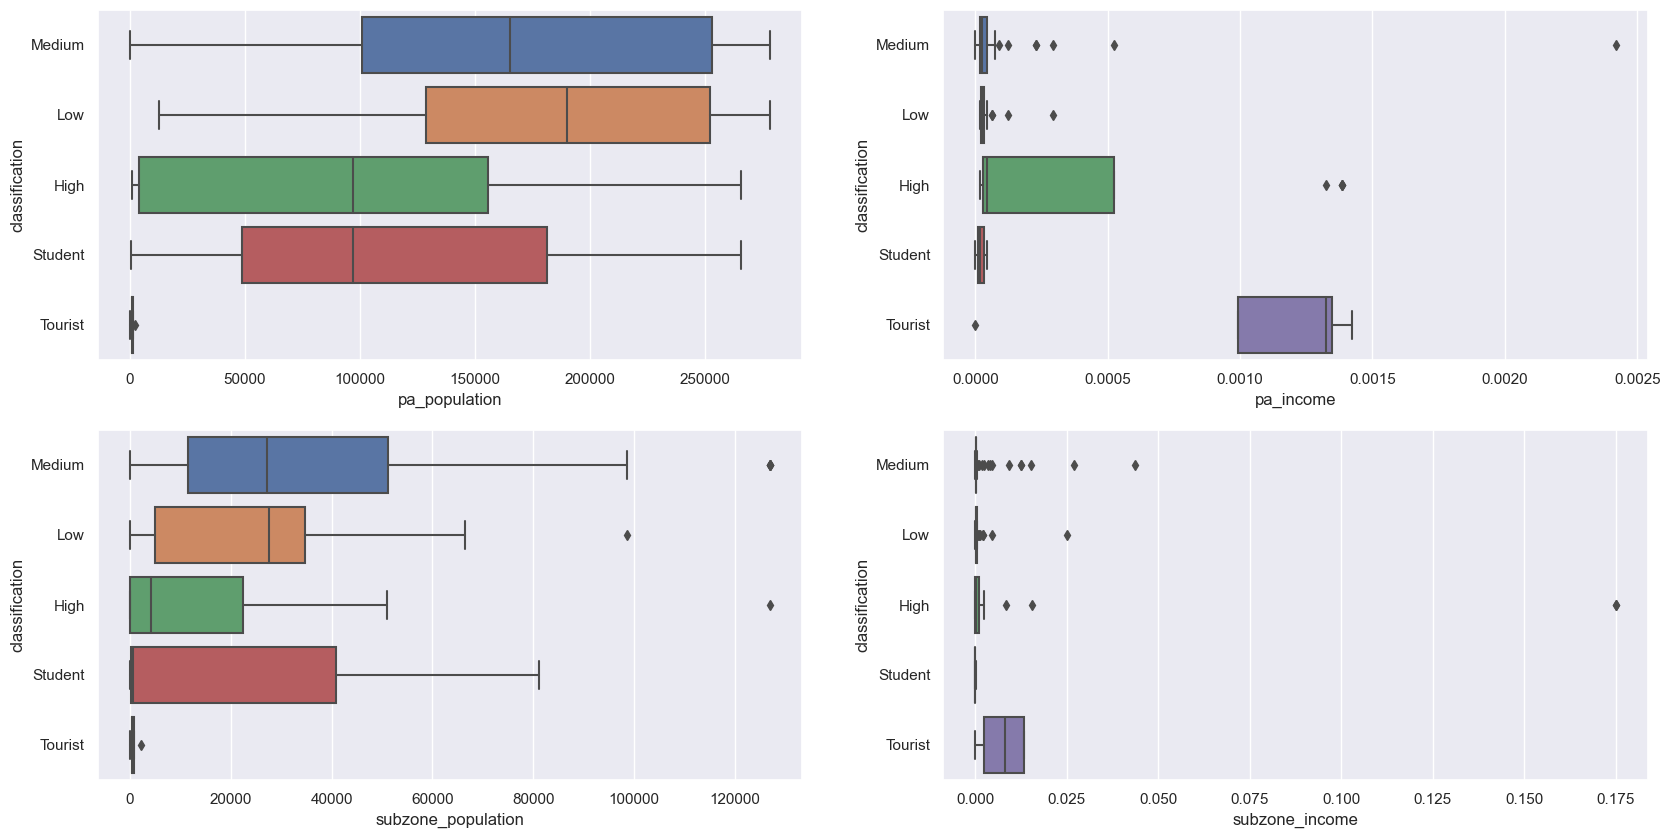

In [ ]:
# plot classification against pa_population, pa_income, subzone_population and subzone_income
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(x='pa_population', y='classification', data=mcd_df, ax=ax[0,0])
sns.boxplot(x='pa_income', y='classification', data=mcd_df, ax=ax[0,1])
sns.boxplot(x='subzone_population', y='classification', data=mcd_df, ax=ax[1,0])
sns.boxplot(x='subzone_income', y='classification', data=mcd_df, ax=ax[1,1])

# for ax[1,1], limit the x-axis to 0.05
plt.show()

### Outliers
We should check for outliers to see if there are any to remove from our dataset. Specifically for this dataset we want to see if there are certain McDonalds are priced a certain way no matter the features we put in. This would affect the model training performance. Previously we already concluded that 'Tourist' and 'Student' are probably not very worth evaluating since it's easy to classify them and the sample size is small

In [ ]:
mcd_df[mcd_df['title'].str.contains('Centre')]

,title,address,latitude,longitude,classification,planning_area,pa_population,pa_income,subzone,subzone_population,subzone_income,makan index,region,region_type,population,size,density,24 hours?,property_type,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKEN

In [ ]:
# print out classification of Mcdonalds with CC in their name
mcd_df[mcd_df['title'].str.contains('CC')]['classification'].value_counts()

Medium    5
Low       1
Name: classification, dtype: int64

In [ ]:
# print out classification of Mcdonalds with Mall or Point in their name
mcd_df[mcd_df['title'].str.contains('Mall|Point|Centre|Plaza')]['classification'].value_counts()

Medium     21
Low         8
High        2
Tourist     1
Name: classification, dtype: int64

In [ ]:
# print out classification of Mcdonalds with Shell or SAFRA or Sports in their name
mcd_df[mcd_df['title'].str.contains('Shell|SAFRA|Sports')]['classification'].value_counts()

High    8
Name: classification, dtype: int64

In [ ]:
mcd_df[mcd_df['title'].str.contains('Shell|SAFRA|Sports')]

,title,address,latitude,longitude,classification,planning_area,makan index,region,region_type,population,size,density,property_type,24 hours?,WEEKDAY_0_in_2,WEEKDAY_0_in_1,WEEKDAY_0_in_0.5,WEEKDAY_0_in_0.2,WEEKDAY_1_in_2,WEEKDAY_1_in_1,WEEKDAY_1_in_0.5,WEEKDAY_1_in_0.2,WEEKDAY_2_in_2,WEEKDAY_2_in_1,WEEKDAY_2_in_0.5,WEEKDAY_2_in_0.2,WEEKDAY_3_in_2,WEEKDAY_3_in_1,WEEKDAY_3_in_0.5,WEEKDAY_3_in_0.2,WEEKDAY_4_in_2,WEEKDAY_4_in_1,WEEKDAY_4_in_0.5,WEEKDAY_4_in_0.2,WEEKDAY_5_in_2,WEEKDAY_5_in_1,WEEKDAY_5_in_0.5,WEEKDAY_5_in_0.2,WEEKDAY_6_in_2,WEEKDAY_6_in_1,WEEKDAY_6_in_0.5,WEEKDAY_6_in_0.2,WEEKDAY_7_in_2,WEEKDAY_7_in_1,WEEKDAY_7_in_0.5,WEEKDAY_7_in_0.2,WEEKDAY_8_in_2,WEEKDAY_8_in_1,WEEKDAY_8_in_0.5,WEEKDAY_8_in_0.2,WEEKDAY_9_in_2,WEEKDAY_9_in_1,WEEKDAY_9_in_0.5,WEEKDAY_9_in_0.2,WEEKDAY_10_in_2,WEEKDAY_10_in_1,WEEKDAY_10_in_0.5,WEEKDAY_10_in_0.2,WEEKDAY_11_in_2,WEEKDAY_11_in_1,WEEKDAY_11_in_0.5,WEEKDAY_11_in_0.2,WEEKDAY_12_in_2,WEEKDAY_12_in_1,WEEKDAY_12_in_0.5,WEEKDAY_12_in_0.2,WEEKDAY_13_in_2,WEEKDAY_13_in_1,WEEKDAY_13_in_0.5,WEEKDAY_13_in_0.2,WEEKDAY_14_in_2,WEEKDAY_14_in_1,WEEKDAY_14_in_0.5,WEEKDAY_14_in_0.2,WEEKDAY_15_in_2,WEEKDAY_15_in_1,WEEKDAY_15_in_0.5,WEEKDAY_15_in_0.2,WEEKDAY_16_in_2,WEEKDAY_16_in_1,WEEKDAY_16_in_0.5,WEEKDAY_16_in_0.2,WEEKDAY_17_in_2,WEEKDAY_17_in_1,WEEKDAY_17_in_0.5,WEEKDAY_17_in_0.2,WEEKDAY_18_in_2,WEEKDAY_18_in_1,WEEKDAY_18_in_0.5,WEEKDAY_18_in_0.2,WEEKDAY_19_in_2,WEEKDAY_19_in_1,WEEKDAY_19_in_0.5,WEEKDAY_19_in_0.2,WEEKDAY_20_in_2,WEEKDAY_20_in_1,WEEKDAY_20_in_0.5,WEEKDAY_20_in_0.2,WEEKDAY_21_in_2,WEEKDAY_21_in_1,WEEKDAY_21_in_0.5,WEEKDAY_21_in_0.2,WEEKDAY_22_in_2,WEEKDAY_22_in_1,WEEKDAY_22_in_0.5,WEEKDAY_22_in_0.2,WEEKDAY_23_in_2,WEEKDAY_23_in_1,WEEKDAY_23_in_0.5,WEEKDAY_23_in_0.2,WEEKENDS_HOLIDAY_0_in_2,WEEKENDS_HOLIDAY_0_in_1,WEEKENDS_HOLIDAY_0_in_0.5,WEEKENDS_HOLIDAY_0_in_0.2,WEEKENDS_HOLIDAY_1_in_2,WEEKENDS_HOLIDAY_1_in_1,WEEKENDS_HOLIDAY_1_in_0.5,WEEKENDS_HOLIDAY_1_in_0.2,WEEKENDS_HOLIDAY_2_in_2,WEEKENDS_HOLIDAY_2_in_1,WEEKENDS_HOLIDAY_2_in_0.5,WEEKENDS_HOLIDAY_2_in_0.2,WEEKENDS_HOLIDAY_3_in_2,WEEKENDS_HOLIDAY_3_in_1,WEEKENDS_HOLIDAY_3_in_0.5,WEEKENDS_HOLIDAY_3_in_0.2,WEEKENDS_HOLIDAY_4_in_2,WEEKENDS_HOLIDAY_4_in_1,WEEKENDS_HOLIDAY_4_in_0.5,WEEKENDS_HOLIDAY_4_in_0.2,WEEKENDS_HOLIDAY_5_in_2,WEEKENDS_HOLIDAY_5_in_1,WEEKENDS_HOLIDAY_5_in_0.5,WEEKENDS_HOLIDAY_5_in_0.2,WEEKENDS_HOLIDAY_6_in_2,WEEKENDS_HOLIDAY_6_in_1,WEEKENDS_HOLIDAY_6_in_0.5,WEEKENDS_HOLIDAY_6_in_0.2,WEEKENDS_HOLIDAY_7_in_2,WEEKENDS_HOLIDAY_7_in_1,WEEKENDS_HOLIDAY_7_in_0.5,WEEKENDS_HOLIDAY_7_in_0.2,WEEKENDS_HOLIDAY_8_in_2,WEEKENDS_HOLIDAY_8_in_1,WEEKENDS_HOLIDAY_8_in_0.5,WEEKENDS_HOLIDAY_8_in_0.2,WEEKENDS_HOLIDAY_9_in_2,WEEKENDS_HOLIDAY_9_in_1,WEEKENDS_HOLIDAY_9_in_0.5,WEEKENDS_HOLIDAY_9_in_0.2,WEEKENDS_HOLIDAY_10_in_2,WEEKENDS_HOLIDAY_10_in_1,WEEKENDS_HOLIDAY_10_in_0.5,WEEKENDS_HOLIDAY_10_in_0.2,WEEKENDS_HOLIDAY_11_in_2,WEEKENDS_HOLIDAY_11_in_1,WEEKENDS_HOLIDAY_11_in_0.5,WEEKENDS_HOLIDAY_11_in_0.2,WEEKENDS_HOLIDAY_12_in_2,WEEKENDS_HOLIDAY_12_in_1,WEEKENDS_HOLIDAY_12_in_0.5,WEEKENDS_HOLIDAY_12_in_0.2,WEEKENDS_HOLIDAY_13_in_2,WEEKENDS_HOLIDAY_13_in_1,WEEKENDS_HOLIDAY_13_in_0.5,WEEKENDS_HOLIDAY_13_in_0.2,WEEKENDS_HOLIDAY_14_in_2,WEEKENDS_HOLIDAY_14_in_1,WEEKENDS_HOLIDAY_14_in_0.5,WEEKENDS_HOLIDAY_14_in_0.2,WEEKENDS_HOLIDAY_15_in_2,WEEKENDS_HOLIDAY_15_in_1,WEEKENDS_HOLIDAY_15_in_0.5,WEEKENDS_HOLIDAY_15_in_0.2,WEEKENDS_HOLIDAY_16_in_2,WEEKENDS_HOLIDAY_16_in_1,WEEKENDS_HOLIDAY_16_in_0.5,WEEKENDS_HOLIDAY_16_in_0.2,WEEKENDS_HOLIDAY_17_in_2,WEEKENDS_HOLIDAY_17_in_1,WEEKENDS_HOLIDAY_17_in_0.5,WEEKENDS_HOLIDAY_17_in_0.2,WEEKENDS_HOLIDAY_18_in_2,WEEKENDS_HOLIDAY_18_in_1,WEEKENDS_HOLIDAY_18_in_0.5,WEEKENDS_HOLIDAY_18_in_0.2,WEEKENDS_HOLIDAY_19_in_2,WEEKENDS_HOLIDAY_19_in_1,WEEKENDS_HOLIDAY_19_in_0.5,WEEKENDS_HOLIDAY_19_in_0.2,WEEKENDS_HOLIDAY_20_in_2,WEEKENDS_HOLIDAY_20_in_1,WEEKENDS_HOLIDAY_20_in_0.5,WEEKENDS_HOLIDAY_20_in_0.2,WEEKENDS_HOLIDAY_21_in_2,WEEKENDS_HOLIDAY_21_in_1,WEEKENDS_HOLIDAY_21_in_0.5,WEEKENDS_HOLIDAY_21_in_0.2,WEEKENDS_HOLIDAY_2

In [ ]:
# We want to see if all the Mcdonalds classified with High will be very affected if we remove Sports, SAFRA or Shell
mcd_df[mcd_df.classification == 'High'].shape
# Almost 25% of the McDonalds will be deleted with this

(31, 406)

### Remove datapoints

In [426]:
# drop all rows with title that have "Shell" or "SAFRA" or "Sports"
mcd_df = mcd_df[~mcd_df['title'].str.contains('Shell')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('SAFRA')]
mcd_df = mcd_df[~mcd_df['title'].str.contains('Sports')]

In [425]:
# drop all rows with classification Tourist or Student
mcd_df = mcd_df[mcd_df['classification'] != 'Tourist']
mcd_df = mcd_df[mcd_df['classification'] != 'Student']

### Take a look at data points again

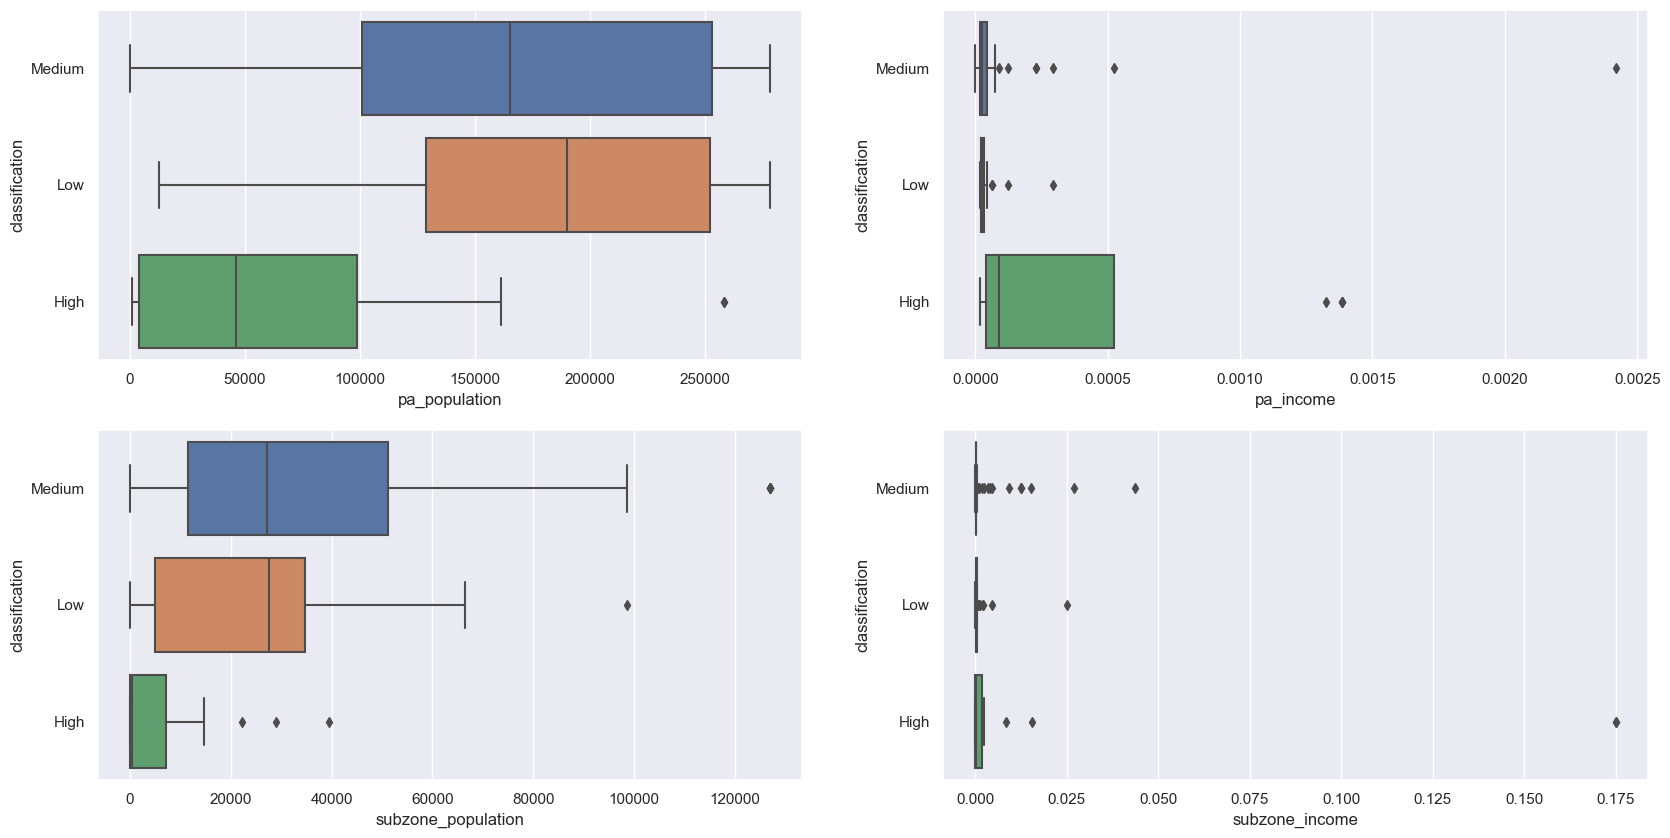

In [ ]:
# plot classification against pa_population, pa_income, subzone_population and subzone_income
fig, ax = plt.subplots(2,2, figsize=(20,10))
sns.boxplot(x='pa_population', y='classification', data=mcd_df, ax=ax[0,0])
sns.boxplot(x='pa_income', y='classification', data=mcd_df, ax=ax[0,1])
sns.boxplot(x='subzone_population', y='classification', data=mcd_df, ax=ax[1,0])
sns.boxplot(x='subzone_income', y='classification', data=mcd_df, ax=ax[1,1])

# for ax[1,1], limit the x-axis to 0.05
# ax[0,1].set_xlim(0,0.0005)
# ax[1,1].set_xlim(0,0.02)
plt.show()

In [ ]:
# convert "classification" to dummy values and then plot a correlation matrix without latitude and longitude
mcd_df_dummies = pd.get_dummies(mcd_df, columns=['classification'])

In [ ]:
mcd_df_dummies.columns

Index(['title', 'address', 'latitude', 'longitude', 'planning_area',
       'pa_population', 'pa_income', 'subzone', 'subzone_population',
       'subzone_income',
       ...
       'hawker_count0.5', 'hawker_count1', 'hawker_count2', 'hdb_count0.2',
       'hdb_count0.5', 'hdb_count1', 'hdb_count2', 'classification_High',
       'classification_Low', 'classification_Medium'],
      dtype='object', length=413)

### Investigating the correlation between the features and the target variable

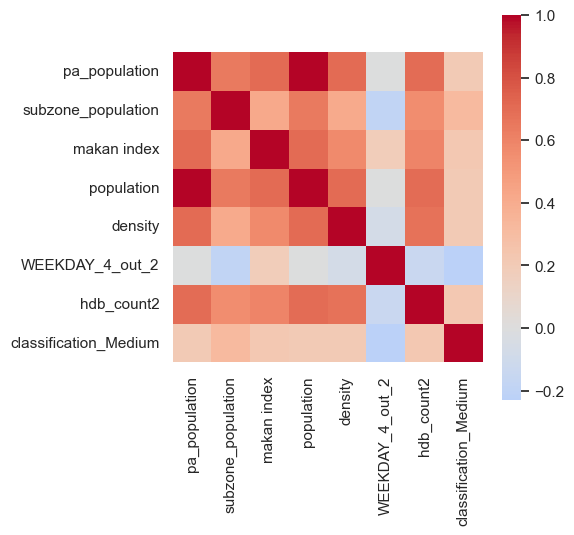

In [436]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.2

# drop the column for low and high classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_Low', 'classification_High'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_Medium']
med_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[med_corr_filtered.index, med_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

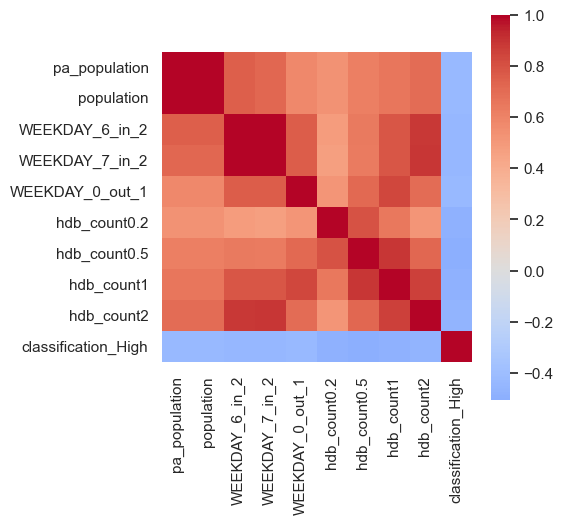

In [439]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.43

# drop the column for other classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_Low', 'classification_Medium'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_High']
high_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[high_corr_filtered.index, high_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

We can see that for the "high" McDonalds, its quite negatively correlated compared to medium with people leaving in the morning and people returning at night. Generally areas with low traffic and public housing are going to be "high"

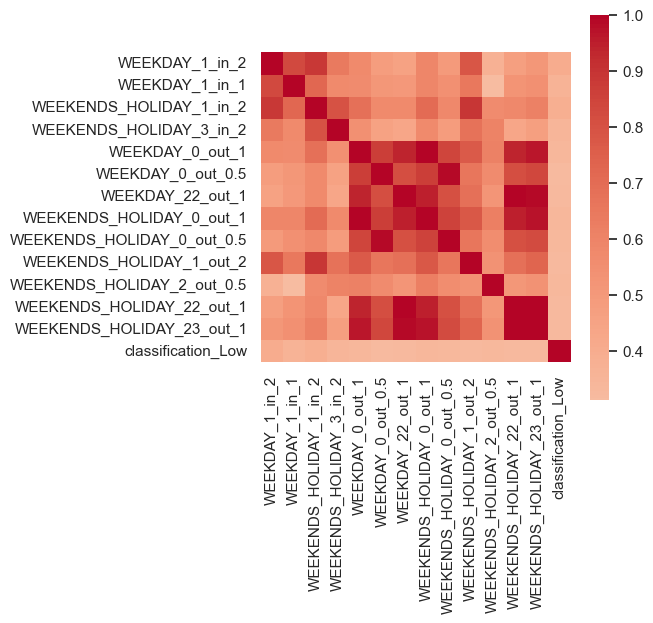

In [443]:
# lets see what are the most correlated features with each of the target classification
threshold = 0.32

# drop the column for other classifications in mcd_df
corr = mcd_df_dummies.drop(['classification_High', 'classification_Medium'], axis=1)
corr_matrix = corr.corr(numeric_only=True)

# Filter out correlations above X for the target variable y
y_corr = corr_matrix['classification_Low']
low_corr_filtered = y_corr[abs(y_corr) >= threshold]

# Create a new correlation matrix with only the filtered correlations
corr_matrix_filtered = corr_matrix.loc[low_corr_filtered.index, low_corr_filtered.index]

# Plot the filtered correlation matrix as a heatmap
sns.set()
fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(corr_matrix_filtered, cmap='coolwarm', center=0, square=True, ax=ax)
plt.show()

Conversely we can see that for the "low" McDonalds, its quite postively correlated with people leaving and coming back in the night

### Looking at other features

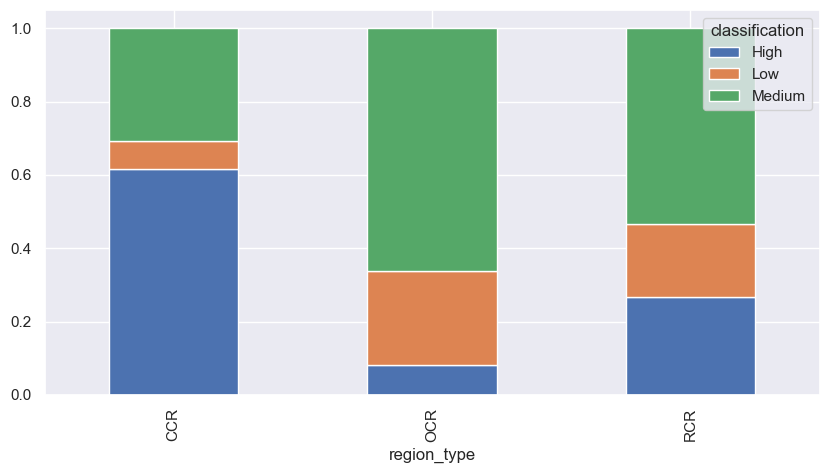

In [444]:
# do a normalized count of classification (without Tourist and Student) against region_type
pd.crosstab(mcd_df['region_type'], mcd_df['classification']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, figsize=(10,5))
plt.show()

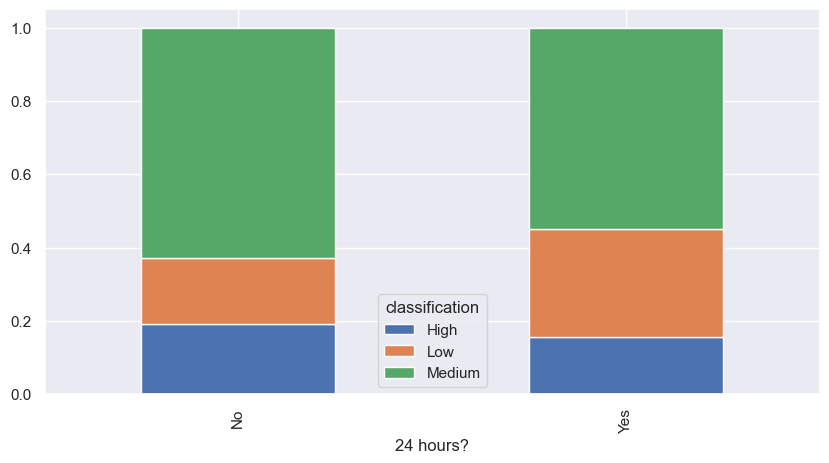

In [428]:
# do a normalized count of classification (without Tourist and Student) against 24 hours?
pd.crosstab(mcd_df['24 hours?'], mcd_df['classification']).apply(lambda r: r/r.sum(), axis=1).plot(kind='bar', stacked=True, figsize=(10,5))
plt.show()

In [429]:
# There are way too many columns so we will select the "best" features to train our model
len(mcd_df.columns)

411

In [446]:
features = [high_corr_filtered.index.tolist(),
            low_corr_filtered.index.tolist(),
            med_corr_filtered.index.tolist()]

# remove duplicates in features
features = list(set([item for sublist in features for item in sublist]))

# remove classification_Low, classification_Medium and classification_High
features.remove('classification_Low')
features.remove('classification_Medium')
features.remove('classification_High')

# remove latitude
# features.remove('latitude')

# add categorical features
features.append('region_type')

# add classification back to features
features.append('classification')

features

['population',
 'WEEKENDS_HOLIDAY_1_in_2',
 'makan index',
 'hdb_count0.5',
 'density',
 'WEEKDAY_7_in_2',
 'WEEKENDS_HOLIDAY_0_out_0.5',
 'hdb_count0.2',
 'WEEKDAY_6_in_2',
 'hdb_count2',
 'WEEKENDS_HOLIDAY_2_out_0.5',
 'WEEKENDS_HOLIDAY_0_out_1',
 'pa_population',
 'WEEKENDS_HOLIDAY_23_out_1',
 'WEEKENDS_HOLIDAY_3_in_2',
 'WEEKDAY_1_in_1',
 'WEEKENDS_HOLIDAY_1_out_2',
 'hdb_count1',
 'WEEKDAY_4_out_2',
 'WEEKDAY_22_out_1',
 'WEEKDAY_0_out_0.5',
 'WEEKENDS_HOLIDAY_22_out_1',
 'WEEKDAY_1_in_2',
 'subzone_population',
 'WEEKDAY_0_out_1',
 'region_type',
 'classification']

In [447]:
mcd_df_model = mcd_df[features]

# Modelling

In [448]:
# train a decision tree classifier
X = mcd_df_model.drop('classification', axis=1)
y = mcd_df_model['classification']

# create dummies for 'Planning Area'
# X = pd.get_dummies(X, columns=['Region Type'], drop_first=True)
# convert X.columns to a list
X.col = list(X.columns)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7922/1368305396.py:8: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [449]:
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object','category']).columns.tolist()
print(numerical_features)
print(categorical_features)

['population', 'WEEKENDS_HOLIDAY_1_in_2', 'makan index', 'hdb_count0.5', 'density', 'WEEKDAY_7_in_2', 'WEEKENDS_HOLIDAY_0_out_0.5', 'hdb_count0.2', 'WEEKDAY_6_in_2', 'hdb_count2', 'WEEKENDS_HOLIDAY_2_out_0.5', 'WEEKENDS_HOLIDAY_0_out_1', 'pa_population', 'WEEKENDS_HOLIDAY_23_out_1', 'WEEKENDS_HOLIDAY_3_in_2', 'WEEKDAY_1_in_1', 'WEEKENDS_HOLIDAY_1_out_2', 'hdb_count1', 'WEEKDAY_4_out_2', 'WEEKDAY_22_out_1', 'WEEKDAY_0_out_0.5', 'WEEKENDS_HOLIDAY_22_out_1', 'WEEKDAY_1_in_2', 'subzone_population', 'WEEKDAY_0_out_1']
['region_type']


In [450]:
# Preprocessing
preprocessor = ColumnTransformer(transformers=[
    ('tnf1',StandardScaler(),numerical_features),
    ('tnf3',OneHotEncoder(),categorical_features)
    ])

# Do class balancing
smote = SMOTE(random_state=42)

# Implement a random forest
rf = RandomForestClassifier()

# create a dictionary of all values we want to test for random forest
params = {
    'classifier__n_estimators': [300, 400, 500, 700],
    'classifier__max_depth': [2, 3, 4, 5, 6],
    'classifier__min_samples_split': [2, 3, 4, 5, 6],
    'classifier__min_samples_leaf': [1, 2, 3, 4, 5],
    'classifier__max_features': ['sqrt', 'log2']
}

pipeline = imbPipeline(steps=[('preprocessor', preprocessor),('smote',smote),('classifier', rf)])

# instantiate the gridsearch
grid = GridSearchCV(pipeline, params, cv=5, scoring ='accuracy', verbose=2)

# fit model to data
grid.fit(X_train, y_train)

# predict the test data
y_pred = grid.predict(X_test)

# print the best parameters
print(grid.best_params_)
print(f'{grid.best_score_}')
print(grid.best_index_)

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   0.1s
[CV] END classifier__max_depth=2, classifier__max_features=sqrt, classifier__min_samples_leaf=1, classifier__min_samples_split=2, classifier__n_estimators=300; total time=   0.2s
[CV] END classifier__max_depth=2, classi

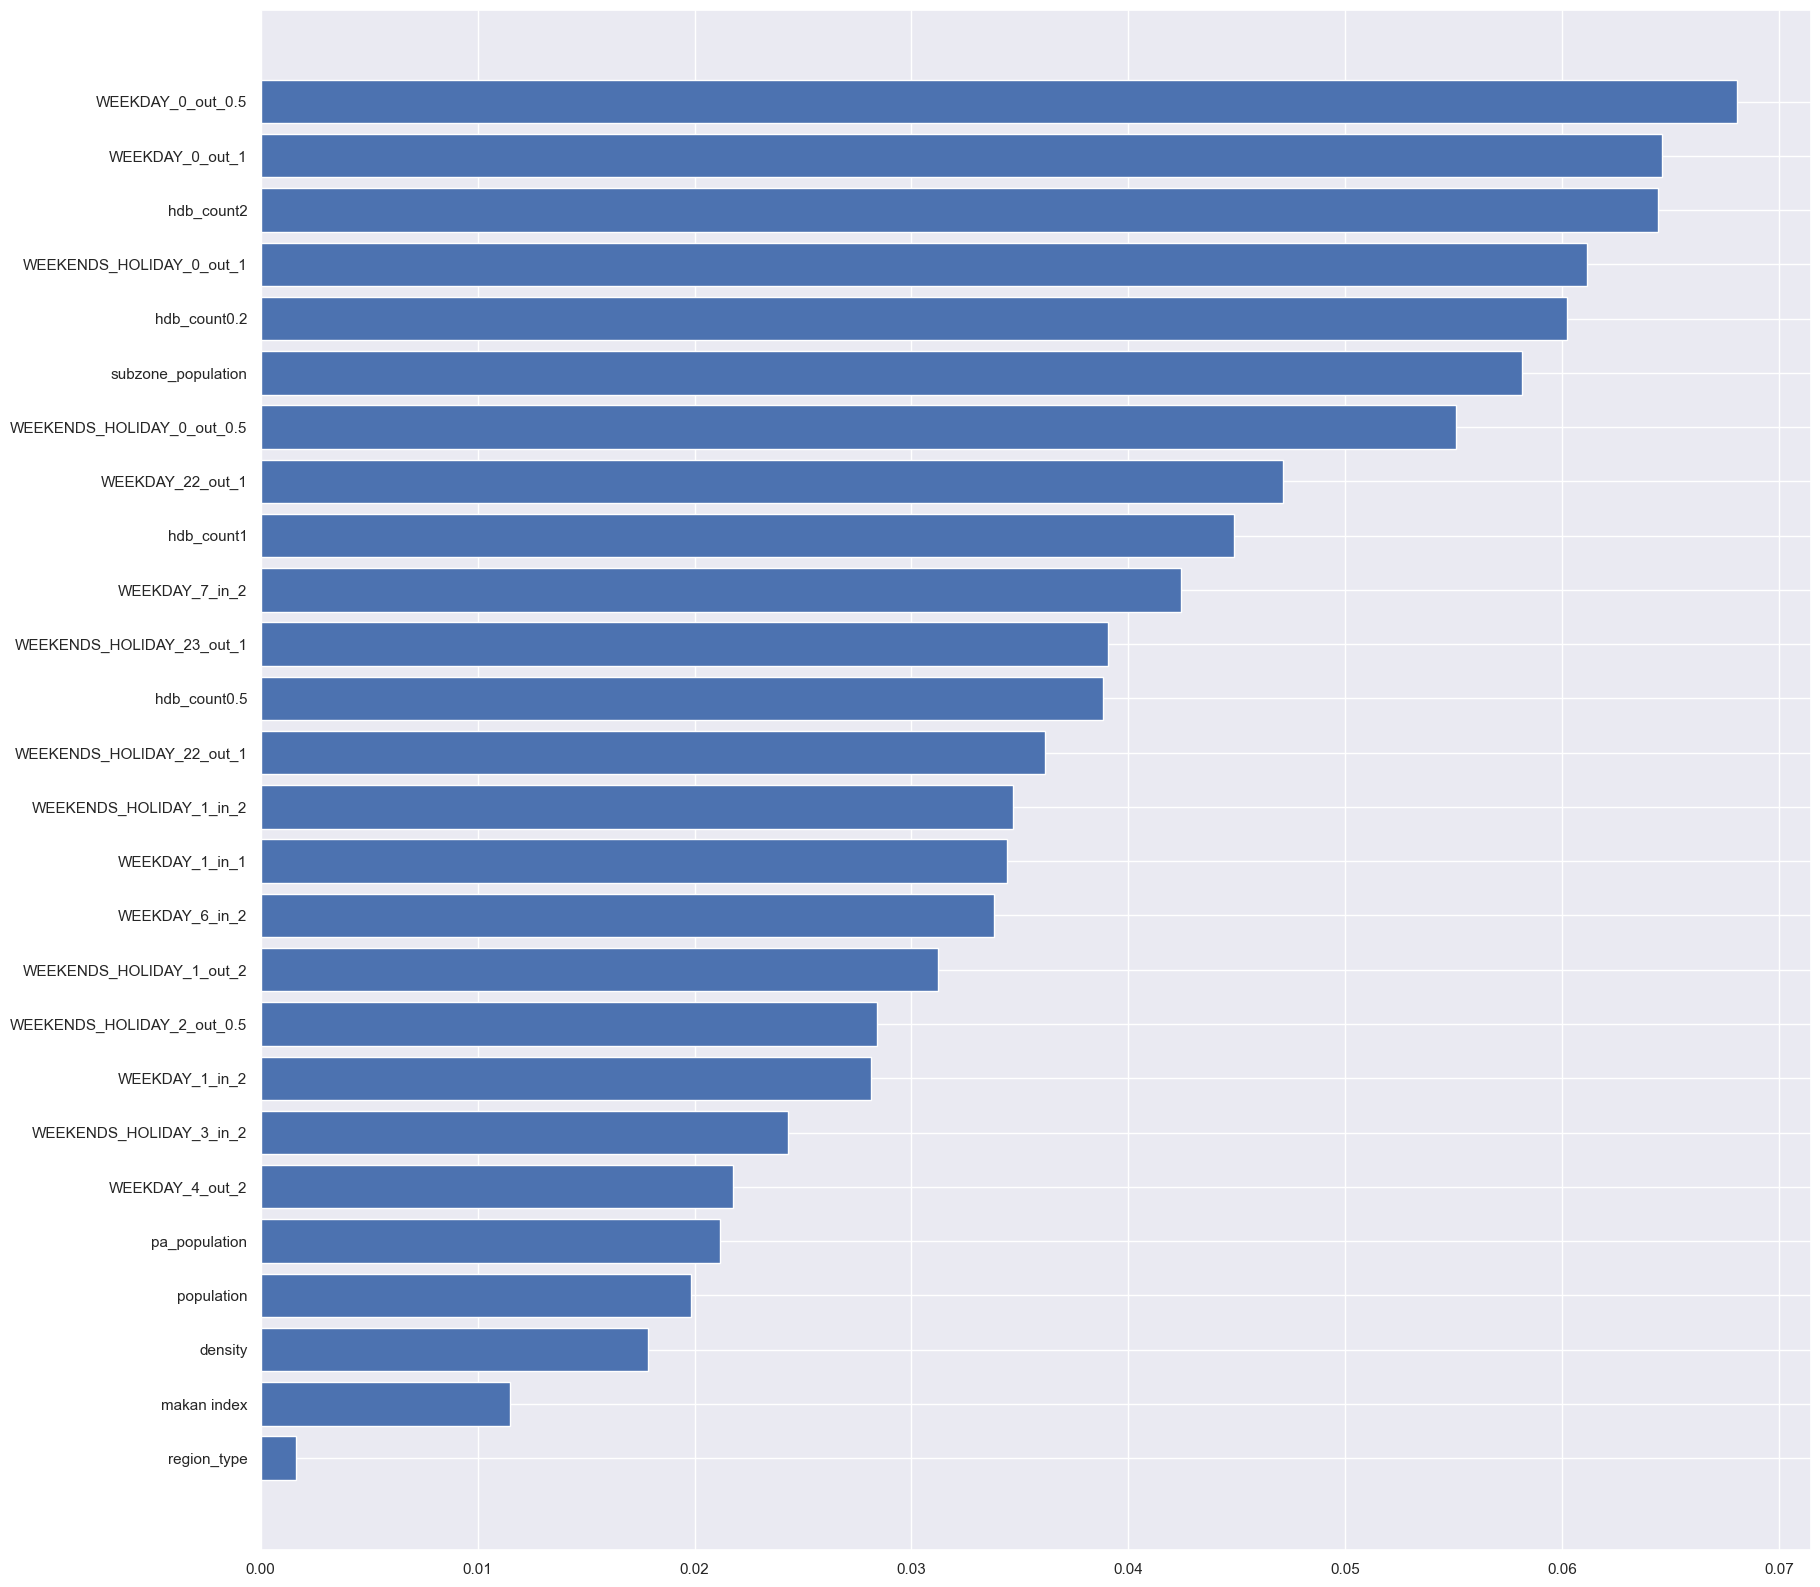

In [451]:
# change fig size to fit all the axis labels
plt.figure(figsize=(20,20))
best = grid.best_estimator_
f_i = list(zip(X.columns,best.named_steps['classifier'].feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i],[x[1] for x in f_i])

plt.show()

In [452]:
# save the gridsearch results
grid_results = pd.DataFrame(grid.cv_results_)
grid_results.to_csv('grid_results.csv')

In [453]:
# print the classification report for the best estimator of the gridsearch results
y_pred = grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test, y_pred, average='weighted')))

              precision    recall  f1-score   support

        High       0.75      0.75      0.75         4
         Low       0.67      1.00      0.80         6
      Medium       0.92      0.75      0.83        16

    accuracy                           0.81        26
   macro avg       0.78      0.83      0.79        26
weighted avg       0.84      0.81      0.81        26

Accuracy: 0.81

Balanced Accuracy: 0.83

Micro Precision: 0.81
Micro Recall: 0.81
Micro F1-score: 0.81

Macro Precision: 0.78
Macro Recall: 0.83
Macro F1-score: 0.79

Weighted Precision: 0.84
Weighted Recall: 0.81
Weighted F1-score: 0.81


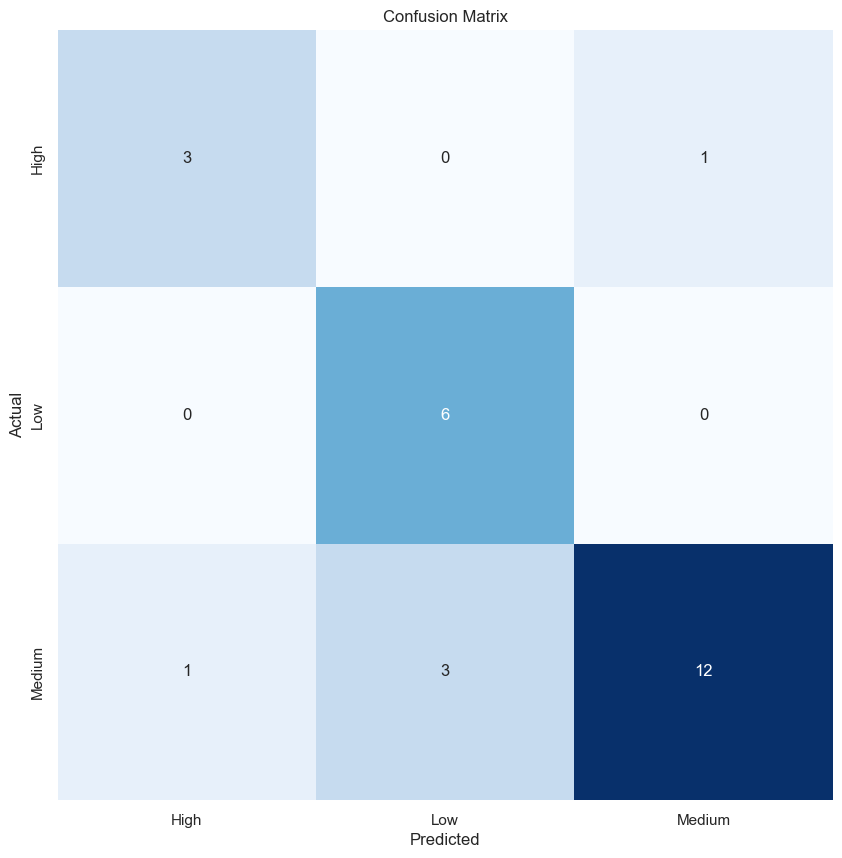

In [454]:
# print confusion matrix with the predicted and actual correct with colors
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# put labels on the predicted and actual labels
plt.xticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])
plt.yticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])

plt.show()

In [ ]:
# implement a XGboost instead
xgb = XGBClassifier()

# train a decision tree classifier
X = mcd_df_model.drop('classification', axis=1)
y = mcd_df_model['classification']

encoder = OneHotEncoder(sparse=False)
y = encoder.fit_transform(y.values.reshape(-1, 1))

# create dummies for 'Planning Area'
# X = pd.get_dummies(X, columns=['Region Type'], drop_first=True)
# convert X.columns to a list
X.col = list(X.columns)

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# create a dictionary of all values we want to test for xgboost
params = {
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__n_estimators': [100, 300, 500],
    'classifier__max_depth': [2, 3, 4, 5, 6],
    # 'classifier__subsample': [0.6, 0.8, 1.0],
    # 'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    # 'classifier__min_child_weight': [1, 3, 5],
    # 'classifier__gamma': [0.0, 0.2, 0.4],
}

pipeline = imbPipeline(steps=[('preprocessor', preprocessor),('smote',smote),('classifier', xgb)])

# instantiate the gridsearch
grid2 = GridSearchCV(pipeline, params, cv=5, verbose=2)

# fit model to data
grid2.fit(X_train, y_train)

# predict the test data
y_pred = grid2.predict(X_test)

# print the best parameters
print(grid2.best_params_)
print(f'{grid2.best_score_}')
print(grid2.best_index_)

/var/folders/nv/vxq64h_j3ydccspj69p0_4_c0000gn/T/ipykernel_7922/1406503541.py:14: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



Fitting 5 folds for each of 45 candidates, totalling 225 fits
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=100; total time=   0.2s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=300; total time=   0.5s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=300; total time=   0.4s
[CV] END classifier__learning_rate=0.01, classifier__max_depth=2, classifier__n_estimators=300; total time=   0.3s
[CV] END classifie

In [ ]:
# print index 11,12,15 of y_test
print(y_test[11])
print(y_test[12])
print(y_test[15])

[0. 0. 1.]
[0. 0. 1.]
[0. 0. 1.]


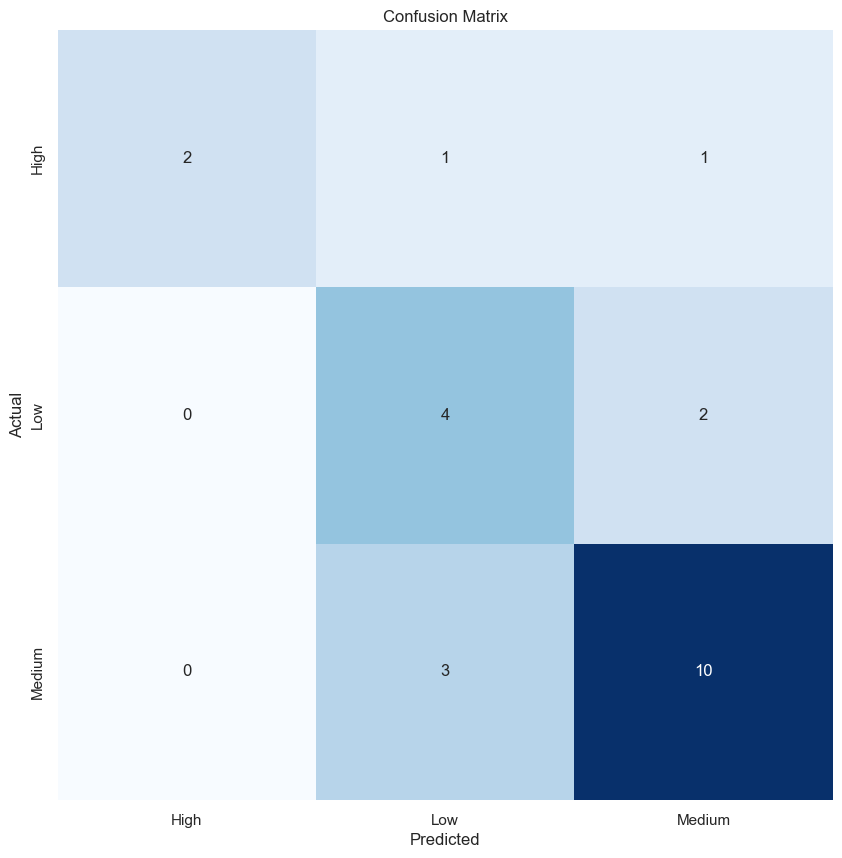

In [ ]:
# # exclude index 11,12,15 from y_pred and y_test results
new_y_pred = np.delete(y_pred, [11,12,15], axis=0)
new_y_test = np.delete(y_test, [11,12,15], axis=0)

# # print confusion matrix with the predicted and actual correct with colors
y_pred_labels = encoder.inverse_transform(new_y_pred)
y_test_labels = encoder.inverse_transform(new_y_test)

cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')

plt.xlabel('Predicted')
plt.ylabel('Actual')

# put labels on the predicted and actual labels
plt.xticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])
plt.yticks([0.5,1.5,2.5], ['High', 'Low', 'Medium'])

plt.show()

In [ ]:
# print the classification report for the best estimator of the gridsearch results
print(classification_report(y_test_labels, y_pred_labels))
print('Accuracy: {:.2f}\n'.format(accuracy_score(y_test_labels, y_pred_labels)))
print('Balanced Accuracy: {:.2f}\n'.format(balanced_accuracy_score(y_test_labels, y_pred_labels)))

print('Micro Precision: {:.2f}'.format(precision_score(y_test_labels, y_pred_labels, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_test_labels, y_pred_labels, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_test_labels, y_pred_labels, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_test_labels, y_pred_labels, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_test_labels, y_pred_labels, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_test_labels, y_pred_labels, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_test_labels, y_pred_labels, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_test_labels, y_pred_labels, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_test_labels, y_pred_labels, average='weighted')))

              precision    recall  f1-score   support

        High       1.00      0.50      0.67         4
         Low       0.50      0.67      0.57         6
      Medium       0.77      0.77      0.77        13

    accuracy                           0.70        23
   macro avg       0.76      0.65      0.67        23
weighted avg       0.74      0.70      0.70        23

Accuracy: 0.70

Balanced Accuracy: 0.65

Micro Precision: 0.70
Micro Recall: 0.70
Micro F1-score: 0.70

Macro Precision: 0.76
Macro Recall: 0.65
Macro F1-score: 0.67

Weighted Precision: 0.74
Weighted Recall: 0.70
Weighted F1-score: 0.70


# Feature Engineering Part 2